In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from pycocotools import mask as mask_utils  # For RLE decoding
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# Load JSON file
json_path = "smoke-segmentation.v5i.coco-segmentation/test/_annotations.coco.json" 
image_folder = "smoke-segmentation.v5i.coco-segmentation/test/"  

with open(json_path, "r") as f:
    data = json.load(f)

# Dictionary mapping category IDs to names
category_map = {cat["id"]: cat["name"] for cat in data["categories"]}

# Choose an image
image_info = data["images"][0]
image_path = os.path.join(image_folder, image_info["file_name"])

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

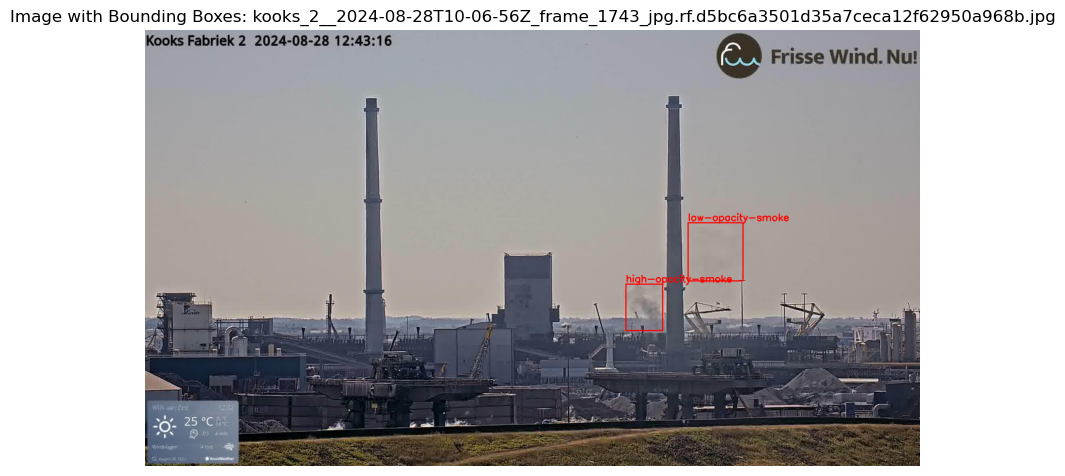

In [2]:
# Load annotations
annotations = [ann for ann in data["annotations"] if ann["image_id"] == image_info["id"]]
# Draw bounding boxes
for ann in annotations:
    x, y, w, h = ann["bbox"]  # COCO format: [x, y, width, height]
    category = category_map[ann["category_id"]]
    # Draw rectangle
    cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
    cv2.putText(image, category, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Image with Bounding Boxes: {image_info['file_name']}")
plt.show()

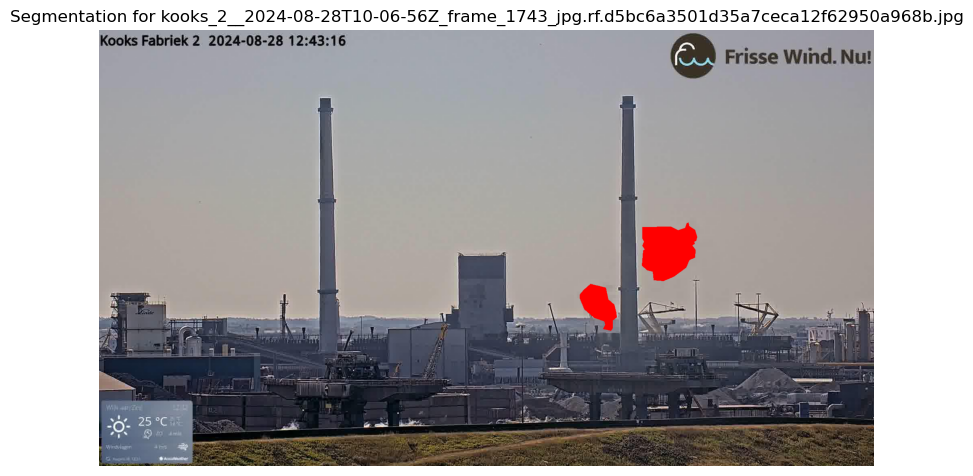

In [5]:
# Mapping category IDs to names
category_map = {cat["id"]: cat["name"] for cat in data["categories"]}

# Select an image
image_info = data["images"][0]  # Choose the first image
image_path = os.path.join(image_folder, image_info["file_name"])

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get annotations for the selected image
annotations = [ann for ann in data["annotations"] if ann["image_id"] == image_info["id"]]

# Create an empty mask
mask = np.zeros((image_info["height"], image_info["width"]), dtype=np.uint8)

# Draw segmentation masks
for ann in annotations:
    category = category_map[ann["category_id"]]

    # If segmentation is in polygon format
    if isinstance(ann["segmentation"], list):
        for seg in ann["segmentation"]:
            poly = np.array(seg, dtype=np.int32).reshape((-1, 2))
            cv2.fillPoly(mask, [poly], color=255)  # Fill the mask with white color

    # If segmentation is in RLE format
    elif isinstance(ann["segmentation"], dict):
        rle = ann["segmentation"]
        binary_mask = mask_utils.decode(rle)  # Decode RLE
        mask[binary_mask > 0] = 255  # Apply to mask

# Overlay the mask onto the image
overlay = image.copy()
overlay[mask > 0] = (255, 0, 0)  # Red color for mask

# Show image with segmentation
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Segmentation for {image_info['file_name']}")
plt.show()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


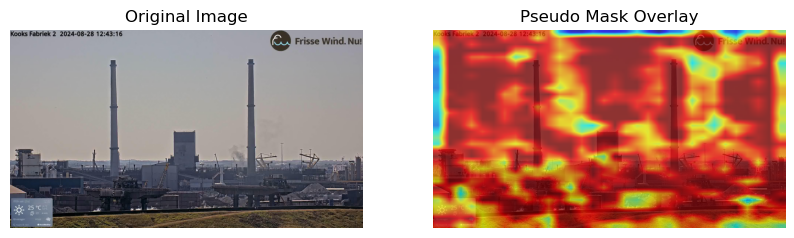

In [6]:
import torch.nn as nn 
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from lib.network.DeepLabV3Plus import DeepLabV3Plus
from lib.network.backbone import choose_backbone
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Grad-CAM function with backpropagation
# Class 1 is the object (foreground)
# Class 0 is the background
def grad_cam(model, img_tensor, target_class=0):
    model.eval()
    
    # Hook to capture the gradients of the convolutional layer
    gradients = None
    feature_map = None
    
    # Correct save_gradient function to accept 3 arguments for backward hook
    def save_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]  # Capture gradients

    # Forward pass with hook
    def forward_hook(module, input, output):
        nonlocal feature_map
        feature_map = output
    
    # Register hooks to capture feature map and gradients
    # Example of selecting a convolutional layer to hook into (e.g., last layer of ASPP)
    # conv_layer = model.backbone.layer4[2].conv3  # Assuming layer4, 2nd block, 3rd conv layer
    conv_layer=model.backbone[6][2].conv3
    conv_layer.register_forward_hook(forward_hook)
    conv_layer.register_backward_hook(save_gradient)
    
    # Forward pass
    output = model(img_tensor.unsqueeze(0))
    # the model outputs a tensor of shape [1, 1, 512, 512], representing a segmentation mask for each pixel (for binary segmentation, this should represent a probability for the foreground or background)
    print("output.shape",output.shape)
        # For binary segmentation, you can select a pixel (e.g., center of the image)
    # Here we select the center pixel (256, 256) for example
    # Adjust this depending on where you want to focus the Grad-CAM on
    center_pixel = (256, 256)
    one_hot = torch.zeros_like(output, dtype=torch.float)
    one_hot[0, target_class, center_pixel[0], center_pixel[1]] = 1 
    # Zero gradients and backward pass
    model.zero_grad()
    

        # Since it's a binary segmentation, select class 1 (foreground) or class 0 (background)
    # In binary segmentation, there is only one channel; thus, output is just a 1D tensor.
    # We can use output[0] directly or use output[0, target_class] for segmentation.
        # For binary segmentation, you can use target_class (0 or 1)
    output.backward(gradient=one_hot, retain_graph=True)
    # output[0, target_class].backward(retain_graph=True) # Only one channel, we use [0, 0] 
    
    # Get the gradients and the feature map
    grad_map = gradients.squeeze(0)
    
    # Weight the feature map by the gradients
    weights = grad_map.mean(dim=(1, 2), keepdim=True)
    cam = (weights * feature_map.squeeze(0)).sum(dim=0)
    cam = F.relu(cam)
    
    # Normalize the CAM
    cam = cam - cam.min()
    cam = cam / cam.max()
    
    return cam

# Visualization of the pseudo mask
def visualize_pseudo_mask(image_path, pseudo_mask):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        print(f"Error: Could not read image from {image_path}")
    
    pseudo_mask = pseudo_mask.detach().cpu().numpy()  # Convert to NumPy for visualization
    
    # Resize pseudo-mask to match image size
    pseudo_mask = cv2.resize(pseudo_mask, (image.shape[1], image.shape[0]))
    
    # Convert pseudo-mask to 3-channel for visualization
    pseudo_mask = np.uint8(255 * pseudo_mask)  # Normalize mask to 0-255
    #pseudo-mask is blended on top of the original image
    pseudo_mask_colored = cv2.applyColorMap(pseudo_mask, cv2.COLORMAP_JET)  # Apply color map
    
    # Blend image and pseudo-mask
    overlay = cv2.addWeighted(image, 0.3, pseudo_mask_colored, 0.7, 0)
    
    # Show result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Pseudo Mask Overlay")
    plt.axis("off")

    plt.show()
    
    

# Example usage
model = choose_backbone('deeplabv3plus_resnet50')
print(model.backbone)
model.load_state_dict(torch.load("/Users/jowonkim/Documents/GitHub/Masterthesis/model/model_full.pth",weights_only=True),strict=False)
model.to(device)

image_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to match model input
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ImageNet weights
])

image = cv2.imread(image_path )
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert to PIL Image before transformation
image = transforms.ToPILImage()(image)
image_tensor = image_transform(image)


# Generate Grad-CAM and visualize
pseudo_mask = grad_cam(model, image_tensor)
visualize_pseudo_mask(image_path, pseudo_mask)

# image_pic = "smoke-segmentation.v5i.coco-segmentation/test/hoogovens_6_7__2024-11-03T07-38-21Z_frame_927_jpg.rf.b585fee20b605ecd1bdeb0553a2f4040.jpg"
